This notebook will do the following:
- Load the training and test data into a dataframe
- Convert them to numpy arrays
- Converting the categorical fields to integer values 
- Transforming skewed numeric features using [BoxCox Transform][1]
- Training an XGB model from the training data using cross-validation
- Applying the trained model on the test data and saving the results to a csv file


  [1]: http://onlinestatbook.com/2/transformations/box-cox.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.dev0.


In [2]:
#Load the training and test files
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
print('training: ', df_train.shape)
print('test: ', df_test.shape)

training:  (188318, 132)
test:  (125546, 131)


In [3]:
#Convert to Numpy arrays and separate features/targets
training_samples = df_train.as_matrix()
training_targets = training_samples[:,-1]
training_samples = training_samples[:,1:-1]

test_samples = df_test.as_matrix()
test_samples = test_samples[:,1:]

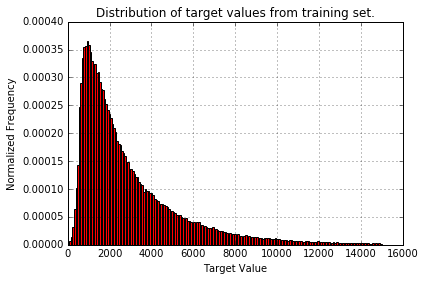

In [4]:
plt.hist(training_targets[np.where(training_targets < 15000)], bins = 200, color='r', normed=True)
plt.grid(True)
plt.xlabel('Target Value')
plt.ylabel('Normalized Frequency')
plt.title('Distribution of target values from training set.')
plt.show()

In [5]:
#Encode the Labels of the categorical data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# [0:116]
allLabels = np.concatenate( ( training_samples[:, 0:116].flat , test_samples[:, 0:116].flat ) )
le.fit( allLabels )
del allLabels
print(le.classes_)

['A' 'AA' 'AB' 'AC' 'AD' 'AE' 'AF' 'AG' 'AH' 'AI' 'AJ' 'AK' 'AL' 'AM' 'AN'
 'AO' 'AP' 'AQ' 'AR' 'AS' 'AT' 'AU' 'AV' 'AW' 'AX' 'AY' 'B' 'BA' 'BB' 'BC'
 'BD' 'BE' 'BF' 'BG' 'BH' 'BI' 'BJ' 'BK' 'BL' 'BM' 'BN' 'BO' 'BP' 'BQ' 'BR'
 'BS' 'BT' 'BU' 'BV' 'BW' 'BX' 'BY' 'C' 'CA' 'CB' 'CC' 'CD' 'CE' 'CF' 'CG'
 'CH' 'CI' 'CJ' 'CK' 'CL' 'CM' 'CN' 'CO' 'CP' 'CQ' 'CR' 'CS' 'CT' 'CU' 'CV'
 'CW' 'CX' 'CY' 'D' 'DA' 'DB' 'DC' 'DD' 'DE' 'DF' 'DG' 'DH' 'DI' 'DJ' 'DK'
 'DL' 'DM' 'DN' 'DO' 'DP' 'DQ' 'DR' 'DS' 'DT' 'DU' 'DV' 'DW' 'DX' 'DY' 'E'
 'EA' 'EB' 'EC' 'ED' 'EE' 'EF' 'EG' 'EH' 'EI' 'EJ' 'EK' 'EL' 'EM' 'EN' 'EO'
 'EP' 'EQ' 'ER' 'ES' 'ET' 'EU' 'EV' 'EW' 'EX' 'EY' 'F' 'FA' 'FB' 'FC' 'FD'
 'FE' 'FF' 'FG' 'FH' 'FI' 'FJ' 'FK' 'FL' 'FM' 'FN' 'FO' 'FP' 'FQ' 'FR' 'FS'
 'FT' 'FU' 'FV' 'FW' 'FX' 'FY' 'G' 'GA' 'GB' 'GC' 'GD' 'GE' 'GF' 'GG' 'GH'
 'GI' 'GJ' 'GK' 'GL' 'GM' 'GN' 'GO' 'GP' 'GQ' 'GR' 'GS' 'GT' 'GU' 'GV' 'GW'
 'GX' 'GY' 'H' 'HA' 'HB' 'HC' 'HD' 'HE' 'HF' 'HG' 'HH' 'HI' 'HJ' 'HK' 'HL'
 'HM' 'HN' 'HO' 'HP'

In [6]:
#Transform the labels to int values
for colIndex in range(116):
    training_samples[:, colIndex] = le.transform(training_samples[:, colIndex])
    test_samples[:, colIndex] = le.transform( test_samples[:, colIndex] )

In [7]:
training_samples = training_samples.astype(np.float)
test_samples = test_samples.astype(np.float)
print(training_samples.shape)
print(test_samples.shape)

(188318, 130)
(125546, 130)


In [8]:
from scipy.stats import skew, boxcox
#Calculate the skew of the features
for featureIdx in range( training_samples.shape[1] ):
    train_test_feature_values = np.concatenate( (training_samples[:,featureIdx], test_samples[:,featureIdx] ), axis=0 )
    skew_ = skew(train_test_feature_values )
    #Transform the numeric features with high skew values
    if abs(skew_) > 0.25 and featureIdx >= 116:
        print(skew_)
        train_test_feature_values = train_test_feature_values + 1
        transformed_feature_values, lm = boxcox( train_test_feature_values )
        training_samples[:,featureIdx] = transformed_feature_values[0:training_samples.shape[0]]
        test_samples[:,featureIdx] = transformed_feature_values[training_samples.shape[0]:]
        

0.5132045516224302
-0.3111459534834093
0.4175592980041423
0.6796104054320997
0.4584132996748133
0.8258887877150827
0.6732370781128026
1.0672469175159112
0.3521162964205932
0.28113943445571493
0.291996918746914
0.37613775584226605
0.25067316370158266


/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-mae:3006.52+4.19215	test-mae:3006.51+12.6596
[50]	train-mae:1891.38+2.69179	test-mae:1893.08+11.4718
[100]	train-mae:1450.83+2.38533	test-mae:1457.04+9.00149
[150]	train-mae:1299.3+1.80671	test-mae:1311.05+7.41516
[200]	train-mae:1244.56+2.34512	test-mae:1261.66+5.01381
[250]	train-mae:1221.34+2.62783	test-mae:1243.14+3.96016
[300]	train-mae:1207.92+2.6762	test-mae:1233.79+3.29406
[350]	train-mae:1197.09+2.41537	test-mae:1226.78+3.17281
[400]	train-mae:1187.56+2.10243	test-mae:1220.63+3.26171
[450]	train-mae:1178.84+2.11157	test-mae:1215.11+3.29127
[500]	train-mae:1170.92+2.00997	test-mae:1210.18+3.35996
[550]	train-mae:1163.63+1.88759	test-mae:1205.88+3.17726
[600]	train-mae:1157.04+1.94609	test-mae:1202.01+3.06477
[650]	train-mae:1151.12+2.00395	test-mae:1198.76+2.92727
[700]	train-mae:1145.75+1.86283	test-mae:1195.95+3.00644
[750]	train-mae:1140.9+1.97652	test-mae:1193.51+2.80633
[800]	train-mae:1136.59+2.06312	test-mae:1191.38+2.60637
[850]	train-mae:1132.73+2.0473	test-m

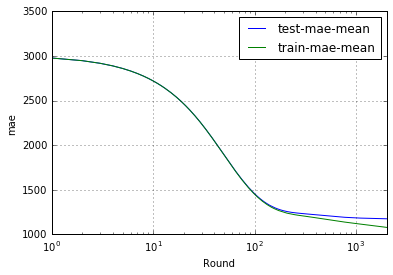

In [9]:
#Train and Cross-Validate using the splits
#We will use xgb for regression with CV for grid search
import xgboost as xgb

#The parameters are taken from these two kernels: 
#    https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter, 
#    https://www.kaggle.com/tilii7/allstate-claims-severity/bias-correction-xgboost
# with minor changes
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.1,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}

dtrain = xgb.DMatrix( training_samples, label=training_targets)
xgb_cv_res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed = 0, stratified=False,
             early_stopping_rounds=25, verbose_eval=50, show_stdv=True)

print('finished cv.')
xgb_cv_res.plot(y=['test-mae-mean', 'train-mae-mean'], grid=True, logx=True)
plt.xlabel('Round')
plt.ylabel('mae')
plt.show()

best_nrounds = xgb_cv_res.shape[0] - 1
xgb_best = xgb.train(xgb_params, dtrain, best_nrounds)   

In [10]:
#Predit for the test data
dtest = xgb.DMatrix( test_samples)
pred_test = xgb_best.predict(dtest)
print(pred_test)

[ 1740.4420166   2145.25512695  9947.02832031 ...,  2843.63427734
  1283.19213867  3673.63110352]


In [11]:
#Save results to csv file
df_res = pd.DataFrame(df_test, columns=['id'])
df_res['loss'] = pred_test
print(df_res.iloc[0])
df_res.to_csv('result.csv', index=False)

id         4.000000
loss    1740.442017
Name: 0, dtype: float32
